<a href="https://colab.research.google.com/github/sudeepmenon17/PytorchforNN/blob/main/WT_for_VIV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install google-auth
from google.colab import auth
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:

!ls /content/drive/MyDrive/Re500_RV5_D0p9

CCcool.mat  Mode_Data  points.mat  Time.mat  VortZ_interp.mat


In [3]:
import os

print(os.listdir('/content/drive/MyDrive/Re500_RV5_D0p9'))


['points.mat', 'Time.mat', 'CCcool.mat', 'Mode_Data', 'VortZ_interp.mat']


In [4]:
from google.colab import drive
drive.mount('/content/drive')

# Correct file paths (case-sensitive!)
VORT_FILE = '/content/drive/MyDrive/Re500_RV5_D0p9/VortZ_interp.mat'
CCCOOL_FILE = '/content/drive/MyDrive/Re500_RV5_D0p9/CCcool.mat'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!find "/content/drive/MyDrive" -iname "VortZ_interp.mat"


/content/drive/MyDrive/Re500_RV5_D0p9/VortZ_interp.mat
/content/drive/MyDrive/Re500_RV5_D0p25/VortZ_interp.mat


In [7]:
!ls -lh "/content/drive/MyDrive/Re500_RV5_D0p9"


total 758M
-rw------- 1 root root  291 Dec 23  2024 CCcool.mat
drwx------ 2 root root 4.0K Jan  3  2025 Mode_Data
-rw------- 1 root root  51K Dec 23  2024 points.mat
-rw------- 1 root root  782 Dec 23  2024 Time.mat
-rw------- 1 root root 758M Aug 19 06:03 VortZ_interp.mat


In [8]:
!pip install PyWavelets
import pywt
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# **Wavelet Transform**

**Wavelet Transform at a single spatial point**

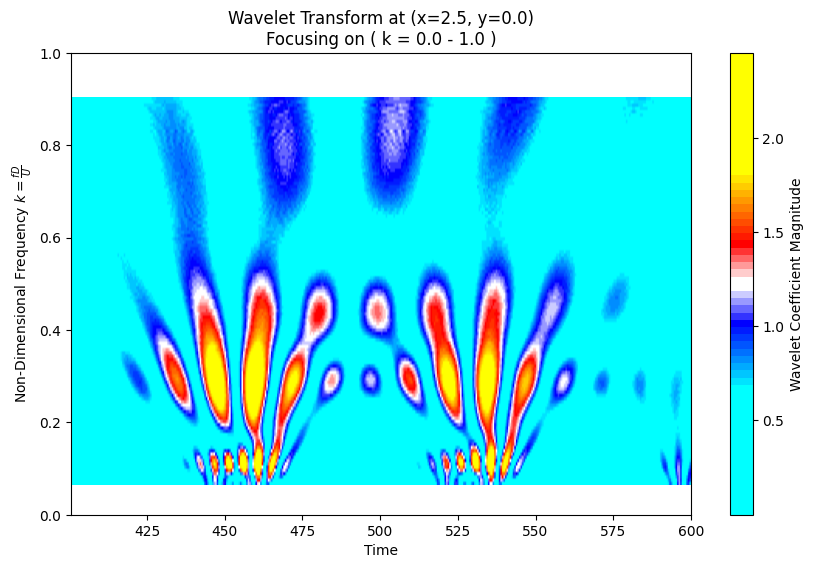

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.io import loadmat
from matplotlib.colors import ListedColormap

# Load Ground_data.mat
file_path = '/content/drive/MyDrive/Re500_RV5_D0p9/VortZ_interp.mat'
data = loadmat(file_path)

Xnew = data['Xnew']  # Vorticity data (grid_points x time_steps)
nxi = int(data['nxi'].item())  # Extract as scalar
nyi = int(data['nyi'].item())  # Extract as scalar
pxnew = data['pxnew'].flatten()  # x-coordinates
pynew = data['pynew'].flatten()  # y-coordinates
Time = data['Time'].flatten()  # Time array
dt = np.mean(np.diff(Time))  # Time step size

# Load CCcool colormap
cccool_data = loadmat('/content/drive/MyDrive/Re500_RV5_D0p9/CCcool.mat')
CC = cccool_data['CC']
custom_cmap = ListedColormap(CC)

# Flow parameters
U = 0.2  # Velocity
D = 1.0  # Characteristic length

# Choose spatial point by coordinates
x_target = 2.5  # Desired x-coordinate
y_target = 0.0  # Desired y-coordinate

# Find the nearest grid point index
distances = np.sqrt((pxnew - x_target)**2 + (pynew - y_target)**2)
nearest_index = np.argmin(distances)  # Index of closest (x, y) point

# Extract vorticity time series at the chosen point
vorticity_series = Xnew[nearest_index, :].flatten()

# Define wavelet scales
scales = np.arange(1, 128)  # Wavelet scales

# Perform Continuous Wavelet Transform (CWT) using Morlet wavelet
coefficients, freqs = pywt.cwt(vorticity_series, scales, 'morl', dt)

# Convert frequency to non-dimensional frequency k = fD/U
k_values = (freqs * D) / U

# Filter for k range 0 - 1.0
valid_indices = np.where((k_values >= 0.0) & (k_values <= 1.0))
filtered_coefficients = coefficients[valid_indices, :][0]
filtered_k_values = k_values[valid_indices]

# Plot wavelet scalogram in terms of non-dimensional frequency k
plt.figure(figsize=(10, 6))
plt.imshow(np.abs(filtered_coefficients), aspect='auto',
           extent=[Time.min(), Time.max(), filtered_k_values.min(), filtered_k_values.max()],
           cmap=custom_cmap, origin='lower')
plt.colorbar(label="Wavelet Coefficient Magnitude")
plt.xlabel("Time")
plt.ylabel(r"Non-Dimensional Frequency $k=\frac{fD}{U}$")
plt.yscale('linear')  # Keep linear scale for better readability in small range
plt.ylim(0.0, 1.0)  # Focus only on the region k = 0.0 - 1.0
plt.title(f"Wavelet Transform at (x={x_target}, y={y_target})\n"
          #f"Closest Grid Point: (x={pxnew[nearest_index]:.2f}, y={pynew[nearest_index]:.2f}), "
          f"Focusing on ( k = 0.0 - 1.0 )")
plt.show()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[INFO] Using:
  VORT_FILE   : /content/drive/MyDrive/Re500_RV5_D0p9/VortZ_interp.mat
  CCCOOL_FILE : /content/drive/MyDrive/Re500_RV5_D0p9/CCcool.mat


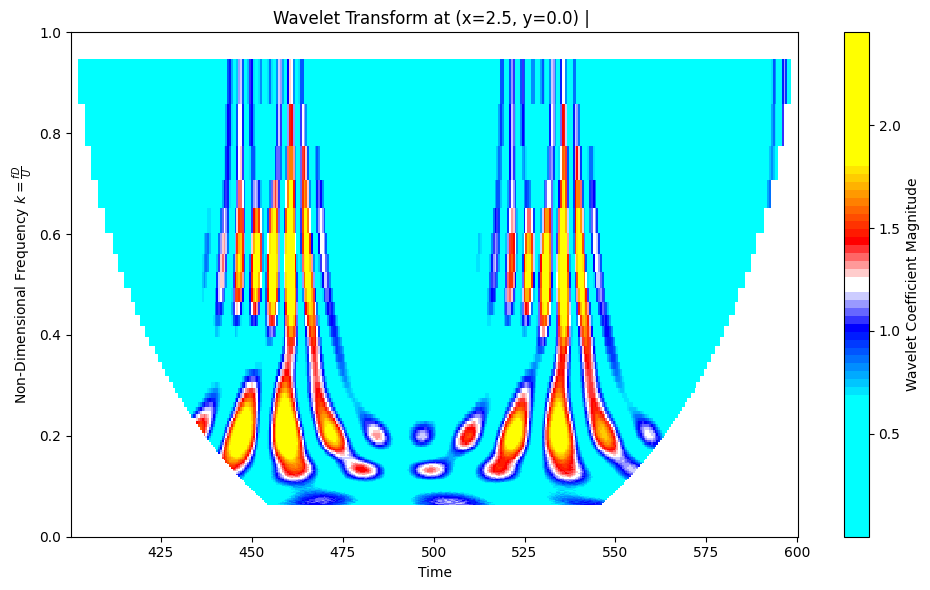

[INFO] dt = 0.5
[INFO] Nearest grid index = 67334, coords=(2.498, -0.007)
[INFO] k-range plotted: [0.0, 1.0]


In [25]:
# -*- coding: utf-8 -*-
# Wavelet scalogram with inverted (convex-up) semi-elliptical bottom cutoff
# Fixed to folder: Re500_RV5_D0p9

import numpy as np
import matplotlib.pyplot as plt
import pywt, os
from scipy.io import loadmat
from matplotlib.colors import ListedColormap
from google.colab import drive

# ── Mount Google Drive ──────────────────────────────────────────────
drive.mount('/content/drive', force_remount=False)

# ── File paths (only D0p9) ──────────────────────────────────────────
ROOT_DIR   = "/content/drive/MyDrive/Re500_RV5_D0p9"
VORT_FILE  = os.path.join(ROOT_DIR, "VortZ_interp.mat")
CCCOOL_FILE = os.path.join(ROOT_DIR, "CCcool.mat")

print("[INFO] Using:")
print("  VORT_FILE   :", VORT_FILE)
print("  CCCOOL_FILE :", CCCOOL_FILE if os.path.exists(CCCOOL_FILE) else "(fallback to viridis)")

# ── User parameters ─────────────────────────────────────────────────
U = 0.2            # velocity
D = 1.0            # characteristic length
x_target, y_target = 2.5, 0.0

SCALES  = np.arange(1, 128)   # wavelet scales
WAVELET = 'morl'
K_MIN_PLOT, K_MAX_PLOT = 0.0, 1.0

# Inverted semi-ellipse mask controls
K_CAP  = 1.2   # height at the ends (mask strongest at edges)
K_BASE = -0.07   # baseline lift (e.g., set 0.05 to raise entire curve)

# ── Load data ──────────────────────────────────────────────────────
data  = loadmat(VORT_FILE)
Xnew  = data['Xnew']                      # (grid_points, time_steps)
pxnew = np.ravel(data['pxnew'])           # len = grid_points
pynew = np.ravel(data['pynew'])
Time  = np.ravel(data['Time'])            # len = time_steps
dt    = float(np.mean(np.diff(Time)))

# Colormap
try:
    CC = loadmat(CCCOOL_FILE)['CC']
    custom_cmap = ListedColormap(CC)
except Exception as e:
    print(f"[WARN] {e}. Falling back to 'viridis'.")
    custom_cmap = 'viridis'

# ── Pick nearest spatial point ─────────────────────────────────────
distances = np.sqrt((pxnew - x_target)**2 + (pynew - y_target)**2)
nearest_index = int(np.argmin(distances))
x_closest, y_closest = float(pxnew[nearest_index]), float(pynew[nearest_index])
vorticity_series = np.ravel(Xnew[nearest_index, :])

# ── CWT and k-conversion ───────────────────────────────────────────
coefficients, freqs = pywt.cwt(vorticity_series, SCALES, WAVELET, dt)
k_values = (freqs * D) / U

valid_k = (k_values >= K_MIN_PLOT) & (k_values <= K_MAX_PLOT)
k = k_values[valid_k]
C = np.abs(coefficients[valid_k, :])     # (n_k, n_t)

t = Time
Tg, Kg = np.meshgrid(t, k)

# ── Inverted (convex-up) semi-ellipse cutoff ──────────────────────
tmid = 0.5 * (t.min() + t.max())
a    = 0.5 * (t.max() - t.min())
x    = (Tg - tmid) / a

k_min = np.full_like(Tg, K_BASE, dtype=float)
inside = np.abs(x) <= 1.0
k_min[inside] += K_CAP * (1.0 - np.sqrt(1.0 - x[inside]**2))

# Mask below curve
mask = Kg < k_min
C_masked = np.ma.masked_where(mask, C)

# ── Plot ──────────────────────────────────────────────────────────
plt.figure(figsize=(10, 6))
im = plt.pcolormesh(Tg, Kg, C_masked, shading='auto', cmap=custom_cmap)
plt.colorbar(im, label="Wavelet Coefficient Magnitude")
plt.xlabel("Time")
plt.ylabel(r"Non-Dimensional Frequency $k=\frac{fD}{U}$")
plt.ylim(K_MIN_PLOT, K_MAX_PLOT)
plt.title(
    f"Wavelet Transform at (x={x_target}, y={y_target}) | "
    #f"Closest grid point: (x={x_closest:.2f}, y={y_closest:.2f})\n"
    #f"Inverted semi-ellipse mask (K_CAP={K_CAP}, K_BASE={K_BASE})"
)
plt.tight_layout()
plt.show()

print(f"[INFO] dt = {dt:.6g}")
print(f"[INFO] Nearest grid index = {nearest_index}, coords=({x_closest:.3f}, {y_closest:.3f})")
print(f"[INFO] k-range plotted: [{K_MIN_PLOT}, {K_MAX_PLOT}]")



# **Extract and Plot the Dominant Frequency Over Time**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.io import loadmat
from matplotlib.colors import ListedColormap

# Load Ground_data.mat
file_path = '/content/drive/MyDrive/Re500_RV5_D0p9/VortZ_interp.mat'
data = loadmat(file_path)

Xnew = data['Xnew']  # Vorticity data (grid_points x time_steps)
nxi = int(data['nxi'].item())  # Extract as scalar
nyi = int(data['nyi'].item())  # Extract as scalar
pxnew = data['pxnew'].flatten()  # x-coordinates
pynew = data['pynew'].flatten()  # y-coordinates
Time = data['Time'].flatten()  # Time array
dt = np.mean(np.diff(Time))  # Time step size

# Flow parameters
U = 0.2  # Velocity
D = 1.0  # Characteristic length

# Choose spatial point by coordinates
x_target = 2.5  # Desired x-coordinate
y_target = 0.5  # Desired y-coordinate

# Find the nearest grid point index
distances = np.sqrt((pxnew - x_target)**2 + (pynew - y_target)**2)
nearest_index = np.argmin(distances)  # Index of closest (x, y) point

# Extract vorticity time series at the chosen point
vorticity_series = Xnew[nearest_index, :].flatten()

# Define wavelet scales
scales = np.arange(1, 128)  # Wavelet scales

# Perform Continuous Wavelet Transform (CWT) using Morlet wavelet
coefficients, freqs = pywt.cwt(vorticity_series, scales, 'morl', dt)

# Convert frequency to non-dimensional frequency k = fD/U
k_values = (freqs * D) / U

# Find the dominant frequency at each time step
dominant_indices = np.argmax(np.abs(coefficients), axis=0)  # Index of max coefficient at each time step
dominant_frequencies = k_values[dominant_indices]  # Extract corresponding frequency

# Print dominant frequencies
print("\n🔹 Dominant Frequencies Over Time:")
for t, k in zip(Time, dominant_frequencies):
    print(f"Time: {t:.2f}, Dominant k: {k:.3f}")

# Plot the dominant frequency evolution
plt.figure(figsize=(8, 4))
plt.plot(Time, dominant_frequencies, 'o-', markersize=2, label="Dominant Frequency")
plt.xlabel("Time")
plt.ylabel("Non-Dimensional Frequency \( k \)")
plt.title("Evolution of Dominant Frequency Over Time")
plt.legend()
plt.grid()
plt.ylim(0.1, 0.7)  # Focus on the k range of interest
plt.show()


# **how k = 0.2 and k = 0.4 evolve over time**



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.io import loadmat
from matplotlib.colors import ListedColormap

# Load Ground_data.mat
file_path = '/content/drive/MyDrive/Re500_RV5_D0p9/VortZ_interp.mat'
data = loadmat(file_path)

Xnew = data['Xnew']  # Vorticity data (grid_points x time_steps)
nxi = int(data['nxi'].item())  # Extract as scalar
nyi = int(data['nyi'].item())  # Extract as scalar
pxnew = data['pxnew'].flatten()  # x-coordinates
pynew = data['pynew'].flatten()  # y-coordinates
Time = data['Time'].flatten()  # Time array
dt = np.mean(np.diff(Time))  # Time step size

# Flow parameters
U = 0.2  # Velocity
D = 1.0  # Characteristic length

# Choose spatial point by coordinates
x_target = 2.5  # Desired x-coordinate
y_target = 0.5  # Desired y-coordinate

# Find the nearest grid point index
distances = np.sqrt((pxnew - x_target)**2 + (pynew - y_target)**2)
nearest_index = np.argmin(distances)  # Index of closest (x, y) point

# Extract vorticity time series at the chosen point
vorticity_series = Xnew[nearest_index, :].flatten()

# Define wavelet scales
scales = np.arange(1, 128)  # Wavelet scales

# Perform Continuous Wavelet Transform (CWT) using Morlet wavelet
coefficients, freqs = pywt.cwt(vorticity_series, scales, 'morl', dt)

# Convert frequency to non-dimensional frequency k = fD/U
k_values = (freqs * D) / U

# Find indices closest to k = 0.2 and k = 0.4
k_0_2_idx = np.argmin(np.abs(k_values - 0.2))
k_0_4_idx = np.argmin(np.abs(k_values - 0.4))

# Extract wavelet coefficients for k = 0.2 and k = 0.4 over time
coeff_k_0_2 = np.abs(coefficients[k_0_2_idx, :])
coeff_k_0_4 = np.abs(coefficients[k_0_4_idx, :])

# Plot the evolution of k = 0.2 and k = 0.4 over time
plt.figure(figsize=(8, 5))
plt.plot(Time, coeff_k_0_2, label="\( k = 0.2 \)", linewidth=1.5)
plt.plot(Time, coeff_k_0_4, label="\( k = 0.4 \)", linewidth=1.5)
plt.xlabel("Time")
plt.ylabel("Wavelet Coefficient Magnitude")
plt.title("Evolution of Wavelet Coefficients for \( k = 0.2 \) and \( k = 0.4 \)")
plt.legend()
plt.grid()
plt.show()


# **time-averaged wavelet power spectrum**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.io import loadmat

# Load Ground_data.mat
file_path = '/content/drive/MyDrive/Re500_RV5_D0p9/VortZ_interp.mat'
data = loadmat(file_path)

Xnew = data['Xnew']  # Vorticity data (grid_points x time_steps)
nxi = int(data['nxi'].item())  # Extract as scalar
nyi = int(data['nyi'].item())  # Extract as scalar
pxnew = data['pxnew'].flatten()  # x-coordinates
pynew = data['pynew'].flatten()  # y-coordinates
Time = data['Time'].flatten()  # Time array
dt = np.mean(np.diff(Time))  # Time step size

# Flow parameters
U = 0.2  # Velocity
D = 1.0  # Characteristic length

# Choose spatial point by coordinates
x_target = 2.5  # Desired x-coordinate
y_target = 0.5  # Desired y-coordinate

# Find the nearest grid point index
distances = np.sqrt((pxnew - x_target)**2 + (pynew - y_target)**2)
nearest_index = np.argmin(distances)  # Index of closest (x, y) point

# Extract vorticity time series at the chosen point
vorticity_series = Xnew[nearest_index, :].flatten()

# Define wavelet scales
scales = np.arange(1, 128)  # Wavelet scales

# Perform Continuous Wavelet Transform (CWT) using Morlet wavelet
coefficients, freqs = pywt.cwt(vorticity_series, scales, 'morl', dt)

# Convert frequency to non-dimensional frequency k = fD/U
k_values = (freqs * D) / U

# Compute time-averaged wavelet power spectrum (Mean of |coefficients|² over time)
wavelet_power = np.mean(np.abs(coefficients) ** 2, axis=1)

# Print dominant frequencies based on highest power
dominant_k_idx = np.argmax(wavelet_power)  # Index of most powerful mode
print(f"\n🔹 Most dominant frequency: k = {k_values[dominant_k_idx]:.3f}")

# Plot the time-averaged wavelet power spectrum
plt.figure(figsize=(8, 4))
plt.plot(k_values, wavelet_power, 'o-', label="Time-Averaged Wavelet Power")
plt.xlabel("Non-Dimensional Frequency \( k \)")
plt.ylabel("Wavelet Power")
plt.title("Time-Averaged Wavelet Power Spectrum")
plt.xlim(0.1, 0.7)  # Focus on dominant range
plt.legend()
plt.grid()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.io import loadmat

# Load Ground_data.mat
file_path = '/content/drive/MyDrive/Re500_RV5_D0p9/VortZ_interp.mat'
data = loadmat(file_path)

Xnew = data['Xnew']  # Vorticity data (grid_points x time_steps)
nxi = int(data['nxi'].item())  # Extract as scalar
nyi = int(data['nyi'].item())  # Extract as scalar
pxnew = data['pxnew'].flatten()  # x-coordinates
pynew = data['pynew'].flatten()  # y-coordinates
Time = data['Time'].flatten()  # Time array
dt = np.mean(np.diff(Time))  # Time step size

# Flow parameters
U = 0.2  # Velocity
D = 1.0  # Characteristic length

# Choose spatial point by coordinates
x_target = 4.0  # Desired x-coordinate
y_target = -2.0  # Desired y-coordinate

# Find the nearest grid point index
distances = np.sqrt((pxnew - x_target)**2 + (pynew - y_target)**2)
nearest_index = np.argmin(distances)  # Index of closest (x, y) point

# Extract vorticity time series at the chosen point
vorticity_series = Xnew[nearest_index, :].flatten()

# Define wavelet scales
scales = np.arange(1, 128)  # Wavelet scales

# Perform Continuous Wavelet Transform (CWT) using Morlet wavelet
coefficients, freqs = pywt.cwt(vorticity_series, scales, 'morl', dt)

# Convert frequency to non-dimensional frequency k = fD/U
k_values = (freqs * D) / U

# Compute time-averaged wavelet power spectrum (Mean of |coefficients|² over time)
wavelet_power = np.mean(np.abs(coefficients) ** 2, axis=1)

# Print dominant frequencies based on highest power
dominant_k_idx = np.argmax(wavelet_power)  # Index of most powerful mode
print(f"\n🔹 Most dominant frequency: k = {k_values[dominant_k_idx]:.3f}")

# Plot the time-averaged wavelet power spectrum
plt.figure(figsize=(8, 4))
plt.plot(k_values, wavelet_power, 'o-', label="Time-Averaged Wavelet Power")
plt.xlabel("Non-Dimensional Frequency \( k \)")
plt.ylabel("Wavelet Power")
plt.title("Time-Averaged Wavelet Power Spectrum")
plt.xlim(0.1, 0.7)  # Focus on dominant range
plt.legend()
plt.grid()
plt.show()


# **Multi-Point Wavelet Analysis**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler

# Load Ground_data.mat
file_path = '/content/drive/MyDrive/Re500_RV5_D0p9/VortZ_interp.mat'
data = loadmat(file_path)

Xnew = data['Xnew']  # Vorticity data (grid_points x time_steps)
nxi = int(data['nxi'].item())  # Extract as scalar
nyi = int(data['nyi'].item())  # Extract as scalar
pxnew = data['pxnew'].flatten()  # x-coordinates
pynew = data['pynew'].flatten()  # y-coordinates
Time = data['Time'].flatten()  # Time array
dt = np.mean(np.diff(Time))  # Time step size

# Flow parameters
U = 0.2  # Velocity
D = 1.0  # Characteristic length

# Define multiple spatial points for analysis
points = [(5.0, 0.5), (5.0, -2.0)]  # (x, y) locations

# Define wavelet scales
scales = np.arange(1, 128)  # Wavelet scales

# Set up subplots
fig, axes = plt.subplots(len(points), 1, figsize=(10, 6 * len(points)), sharex=True)

for i, (x_target, y_target) in enumerate(points):
    # Find the nearest grid point index
    distances = np.sqrt((pxnew - x_target) ** 2 + (pynew - y_target) ** 2)
    nearest_index = np.argmin(distances)  # Index of closest (x, y) point

    # Extract vorticity time series at the chosen point
    vorticity_series = Xnew[nearest_index, :].flatten()

    # Perform Continuous Wavelet Transform (CWT) using Morlet wavelet
    coefficients, freqs = pywt.cwt(vorticity_series, scales, 'morl', dt)

    # Convert frequency to non-dimensional frequency k = fD/U
    k_values = (freqs * D) / U

    # Normalize wavelet coefficients for better visualization
    scaler = MinMaxScaler(feature_range=(0, 1))  # Normalize between 0 and 1
    norm_coefficients = scaler.fit_transform(np.abs(coefficients))

    # Plot the wavelet scalogram for the current point
    ax = axes[i]
    im = ax.imshow(norm_coefficients, aspect='auto',
                   extent=[Time.min(), Time.max(), k_values.min(), k_values.max()],
                   cmap="jet", origin='lower', vmin=0, vmax=0.4)  # Scale range 0-0.4

    ax.set_ylabel("Non-Dimensional Frequency \( k \)")
    ax.set_title(f"Wavelet Transform at (x={x_target}, y={y_target})")
    ax.set_ylim(0.1, 0.7)  # Focus on k range of interest
    ax.grid()

# Add colorbar
fig.colorbar(im, ax=axes, orientation='vertical', label="Normalized Wavelet Coefficient Magnitude (0-0.4)")
plt.xlabel("Time")
plt.show()


# **Apply Wavelet Analysis to PCA Mode Coefficients**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Load Ground_data.mat
file_path = '/content/drive/MyDrive/Re500_RV5_D0p9/VortZ_interp.mat'
data = loadmat(file_path)

Xnew = data['Xnew']  # Vorticity data (grid_points x time_steps)
nxi = int(data['nxi'].item())  # Extract as scalar
nyi = int(data['nyi'].item())  # Extract as scalar
pxnew = data['pxnew'].flatten()  # x-coordinates
pynew = data['pynew'].flatten()  # y-coordinates
Time = data['Time'].flatten()  # Time array
dt = np.mean(np.diff(Time))  # Time step size

# Define wavelet scales
scales = np.arange(1, 128)  # Wavelet scales

# Perform PCA on vorticity field (each row = grid point, each column = time step)
X_centered = Xnew - np.mean(Xnew, axis=1, keepdims=True)  # Center data
pca = PCA(n_components=3)  # Keep first 3 PCA modes
pca_modes = pca.fit_transform(X_centered.T)  # Time evolution of PCA modes

# Extract first 3 principal components
pca_mode_1 = pca_modes[:, 0]
pca_mode_2 = pca_modes[:, 1]
pca_mode_3 = pca_modes[:, 2]

# Perform Wavelet Transform on first 3 PCA modes
coefficients_1, freqs_1 = pywt.cwt(pca_mode_1, scales, 'morl', dt)
coefficients_2, freqs_2 = pywt.cwt(pca_mode_2, scales, 'morl', dt)
coefficients_3, freqs_3 = pywt.cwt(pca_mode_3, scales, 'morl', dt)

# Convert frequency to non-dimensional frequency k = fD/U
U, D = 0.2, 1.0  # Flow parameters
k_values_1 = (freqs_1 * D) / U
k_values_2 = (freqs_2 * D) / U
k_values_3 = (freqs_3 * D) / U

# Normalize wavelet coefficients for fair comparison
scaler = MinMaxScaler(feature_range=(0, 1))  # Normalize between 0 and 1
norm_coefficients_1 = scaler.fit_transform(np.abs(coefficients_1))
norm_coefficients_2 = scaler.fit_transform(np.abs(coefficients_2))
norm_coefficients_3 = scaler.fit_transform(np.abs(coefficients_3))

# Scale limit for visualization
vmin, vmax = 0, 0.4  # Set color scale limits

# Plot wavelet scalograms for first 3 PCA modes
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

for ax, coeff, k_values, mode_num in zip(axes,
                                         [norm_coefficients_1, norm_coefficients_2, norm_coefficients_3],
                                         [k_values_1, k_values_2, k_values_3],
                                         [1, 2, 3]):
    im = ax.imshow(coeff, aspect='auto',
                   extent=[Time.min(), Time.max(), k_values.min(), k_values.max()],
                   cmap="jet", origin='lower', vmin=vmin, vmax=vmax)

    ax.set_ylabel("Non-Dimensional Frequency \( k \)")
    ax.set_title(f"Wavelet Transform of PCA Mode {mode_num} (Normalized, Scale 0-0.4)")
    ax.set_ylim(0.1, 0.7)  # Focus on k range of interest
    ax.grid()

# Add colorbar
fig.colorbar(im, ax=axes, orientation='vertical', label="Normalized Wavelet Coefficient Magnitude")
plt.xlabel("Time")
plt.show()

# Print explained variance ratio
print("\n🔹 Explained Variance Ratios for First 3 PCA Modes:")
for i, variance in enumerate(pca.explained_variance_ratio_[:3]):
    print(f"Mode {i+1}: {variance*100:.2f}%")


# **Wavelet Analysis for PCA Modes of Time Subdivisions**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.io import loadmat
from sklearn.decomposition import PCA

# Load Ground_data.mat
file_path = '/content/drive/MyDrive/Re500_RV5_D0p9/VortZ_interp.mat'
data = loadmat(file_path)

Xnew = data['Xnew']  # Vorticity data (grid_points x time_steps)
nxi = int(data['nxi'].item())  # Extract as scalar
nyi = int(data['nyi'].item())  # Extract as scalar
pxnew = data['pxnew'].flatten()  # x-coordinates
pynew = data['pynew'].flatten()  # y-coordinates
Time = data['Time'].flatten()  # Time array
dt = np.mean(np.diff(Time))  # Time step size

# Define wavelet scales
scales = np.arange(1, 128)  # Wavelet scales

# Divide time series into 8 equal subdivisions
n_subdivisions = 8
time_samples = Xnew.shape[1]
subdivision_size = time_samples // n_subdivisions

# Select Subdivision 1 and Subdivision 3
subdivisions = [1, 3]  # First and third subdivisions
pca_results = {}  # Store PCA results for each subdivision

for subdiv in subdivisions:
    # Define time range for the subdivision
    start_idx = (subdiv - 1) * subdivision_size
    end_idx = subdiv * subdivision_size
    X_sub = Xnew[:, start_idx:end_idx]

    # Perform PCA on the subdivision
    X_centered = X_sub - np.mean(X_sub, axis=1, keepdims=True)
    pca = PCA(n_components=3)
    pca_modes = pca.fit_transform(X_centered.T)  # Time evolution of PCA modes

    # Extract PCA mode time coefficients
    pca_mode_1, pca_mode_2, pca_mode_3 = pca_modes[:, 0], pca_modes[:, 1], pca_modes[:, 2]

    # Perform Wavelet Transform on PCA mode time coefficients
    coeff_1, freqs_1 = pywt.cwt(pca_mode_1, scales, 'morl', dt)
    coeff_2, freqs_2 = pywt.cwt(pca_mode_2, scales, 'morl', dt)
    coeff_3, freqs_3 = pywt.cwt(pca_mode_3, scales, 'morl', dt)

    # Convert frequency to non-dimensional frequency k = fD/U
    U, D = 0.2, 1.0
    k_values = (freqs_1 * D) / U

    # Apply logarithmic scaling to enhance low-intensity signals
    def log_scale(coeff):
        return np.log1p(np.abs(coeff))  # log(1 + |coeff|) to prevent log(0) issues

    log_coeff_1 = log_scale(coeff_1)
    log_coeff_2 = log_scale(coeff_2)
    log_coeff_3 = log_scale(coeff_3)

    # Store results
    pca_results[subdiv] = {
        "Time": Time[start_idx:end_idx],
        "k_values": k_values,
        "coeff_1": log_coeff_1,
        "coeff_2": log_coeff_2,
        "coeff_3": log_coeff_3,
        "explained_variance": pca.explained_variance_ratio_[:3],
    }

# Plot wavelet scalograms for PCA modes in Time Subdivision 1 and 3
fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharex=True)

for j, subdiv in enumerate(subdivisions):
    results = pca_results[subdiv]
    time_range = results["Time"]
    k_values = results["k_values"]

    for i, (coeff, mode_num) in enumerate(zip(
            [results["coeff_1"], results["coeff_2"], results["coeff_3"]], [1, 2, 3])):

        ax = axes[i, j]
        im = ax.imshow(coeff, aspect='auto',
                       extent=[time_range.min(), time_range.max(), k_values.min(), k_values.max()],
                       cmap="jet", origin='lower')

        ax.set_ylabel("Non-Dimensional Frequency \( k \)")
        ax.set_title(f"Wavelet Transform (Subdiv {subdiv}) - PCA Mode {mode_num} (Log Scale)")
        ax.set_ylim(0.1, 0.7)
        ax.grid()

# Add colorbar
fig.colorbar(im, ax=axes, orientation='vertical', label="Log Scaled Wavelet Coefficient Magnitude")
plt.xlabel("Time")
plt.show()

# Print explained variance ratio for both subdivisions
for subdiv in subdivisions:
    print(f"\n🔹 Explained Variance Ratios for Subdivision {subdiv}:")
    for i, variance in enumerate(pca_results[subdiv]["explained_variance"]):
        print(f"Mode {i+1}: {variance*100:.2f}%")

